# Data Science Capstone

## Problem: 
The experience of people in Chicago, Illinois in the United States varies wildly from neighborhood to neighborhood. I'd like to explore the relationship between the most common venues in a neighborhood and its key economic and sociological indicators. 

Specifically

1. Is there a relationship between number of grocery stores and income level
2. how many grocery stores are there in the highest and lowest income areas per-capita

## Data:
1. Foursquare API: foursquare.com
These data are fundamental to the analysis. The response to the API calls are in the form of JSON files

2. Census Data - Selected socioeconomic indicators in Chicago, 2008 – 2012: https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2
These data contain multiple measures of socioeconic health, including education, housing and income. I will be leveraging the income data primarily.

3. Spreadsheet: 2010 Census Data Summarized :https://datahub.cmap.illinois.gov/dataset/2010-census-data-summarized-to-chicago-community-areas/resource/b30b47bf-bb0d-46b6-853b-47270fb7f626?inner_span=True
This contains the total poulation of each of the community areas related to my analysis

These data will allow us to separate out locations and see which venues are most prevalent. I look forward to evaluating the data and gaining deeper understanidng of a premier global city. The venue data will come from the Foursquare API. The income information will be from the socioeconomic indicators and the population totals will come from the summarized census data.

### Step 1: Import Libraries and Collect Data

In [85]:
import requests 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import json 
import folium
from pandas.io.json import json_normalize

In [86]:
#read in data files
censusData = pd.read_excel('2010_chicago_census.xlsx',header = 1)
socioData = pd.read_csv('Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv')


In [125]:
#Combine relevant data
df1 = censusData.copy()
a=pd.DataFrame({'Neighborhood':df1['Geog'],'Income':socioData['PER CAPITA INCOME '].copy()})
#a=pd.DataFrame({'Neighborhood':df1['Geog'],'Income':socioData['HARDSHIP INDEX'].copy()})
a['Location'] =  a['Neighborhood']+', Chicago Illinois'
a.dropna(axis=0,inplace=True)#drop the NA row
a.head()

,Neighborhood,Income,Location
0,Rogers Park,23939,"Rogers Park, Chicago Illinois"
1,West Ridge,23040,"West Ridge, Chicago Illinois"
2,Uptown,35787,"Uptown, Chicago Illinois"
3,Lincoln Square,37524,"Lincoln Square, Chicago Illinois"
4,North Center,57123,"North Center, Chicago Illinois"


In [89]:
#Find the latittude and longitude of each neihgborhood
geolocator = Nominatim(user_agent="foursquare_agent")#set agent for later location services
locx=[]
locLat=[]
locLong=[]
for i in range(len(a)):    
    x = geolocator.geocode(a['Location'][i],timeout=30)
    locx.append(x)
    locLat.append(x.latitude)
    locLong.append(x.longitude)
    print( round(i/len(a)*100,),'% complete')


0 % complete
1 % complete
3 % complete
4 % complete
5 % complete
6 % complete
8 % complete
9 % complete
10 % complete
12 % complete
13 % complete
14 % complete
16 % complete
17 % complete
18 % complete
19 % complete
21 % complete
22 % complete
23 % complete
25 % complete
26 % complete
27 % complete
29 % complete
30 % complete
31 % complete
32 % complete
34 % complete
35 % complete
36 % complete
38 % complete
39 % complete
40 % complete
42 % complete
43 % complete
44 % complete
45 % complete
47 % complete
48 % complete
49 % complete
51 % complete
52 % complete
53 % complete
55 % complete
56 % complete
57 % complete
58 % complete
60 % complete
61 % complete
62 % complete
64 % complete
65 % complete
66 % complete
68 % complete
69 % complete
70 % complete
71 % complete
73 % complete
74 % complete
75 % complete
77 % complete
78 % complete
79 % complete
81 % complete
82 % complete
83 % complete
84 % complete
86 % complete
87 % complete
88 % complete
90 % complete
91 % complete
92 % complete


In [90]:
#add the lat and lng calues to the dataframe
a['Lat'] = locLat #add latitute and longitute to dataframe
a['Long'] = locLong
a.head()

,Neighborhood,Income,Location,Lat,Long
0,Rogers Park,23939,"Rogers Park, Chicago Illinois",42.010531,-87.670748
1,West Ridge,23040,"West Ridge, Chicago Illinois",42.003548,-87.696243
2,Uptown,35787,"Uptown, Chicago Illinois",41.966630,-87.655546
3,Lincoln Square,37524,"Lincoln Square, Chicago Illinois",41.940298,-87.638117
4,North Center,57123,"North Center, Chicago Illinois",41.956107,-87.679160


### Step 2: Foursquare Data Collection

In [104]:
col1=[]#name of neighborhood
col2=[]#number of grocery stores
CLIENT_ID = 'VYCOUITIGXOONWV3KJ34HKMDN2IAXOLBLRKF0CRIJSXXR1SJ' #  Foursquare ID
CLIENT_SECRET = 'H0ATIVHEOUNIBDCHAVN1YOT2K5GLUT4QT1HNO3VLPU00EIKB' #  Foursquare 
VERSION = '20180605' # Foursquare API version
search_query = ''
radius = 3218/2 # this sets teh radius as 1 mile from the center of each neighborhood to give us a representative sample
LIMIT =1000

#this block returns a JSON of each neighborhood and counts the results and adds the numbe rof results to a new frame
for i in range(len(a)):
    Category= '52f2ab2ebcbc57f1066b8b45,4bf58dd8d48988d118951735, 52f2ab2ebcbc57f1066b8b46' #restrict search to 3 grocery categories
    geolocator = Nominatim(user_agent="foursquare_agent")
    latitude = a['Lat'][i]
    longitude = a['Long'][i]
    #print(latitude, longitude)
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}&CategoryID={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT,Category)
    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    venues = results['response']['venues']
    # tranform venues into a dataframe
    df_data = json_normalize(venues)
    nresult= len(df_data)
    col1.append(a['Neighborhood'][i])
    col2.append(nresult)
    print(a['Location'][i],': Has',nresult,' grocers.')


Rogers Park, Chicago Illinois    179
West Ridge, Chicago Illinois    116
Uptown, Chicago Illinois    127
Lincoln Square, Chicago Illinois    156
North Center, Chicago Illinois    181
Lake View, Chicago Illinois    191
Lincoln Park, Chicago Illinois    156
Near North Side, Chicago Illinois    143
Edison Park, Chicago Illinois    113
Norwood Park, Chicago Illinois    170
Jefferson Park, Chicago Illinois    134
Forest Glen, Chicago Illinois    115
North Park, Chicago Illinois    185
Albany Park, Chicago Illinois    197
Portage Park, Chicago Illinois    108
Irving Park, Chicago Illinois    92
Dunning, Chicago Illinois    165
Montclare, Chicago Illinois    175
Belmont Cragin, Chicago Illinois    181
Hermosa, Chicago Illinois    159
Avondale, Chicago Illinois    116
Logan Square, Chicago Illinois    154
Humboldt Park, Chicago Illinois    149
West Town, Chicago Illinois    169
Austin, Chicago Illinois    131
West Garfield Park, Chicago Illinois    116
East Garfield Park, Chicago Illinois    1

In [105]:
a.dropna(axis=0,inplace=True)#drop the NA row

In [127]:
a.head()

,Neighborhood,Income,Location
0,Rogers Park,23939,"Rogers Park, Chicago Illinois"
1,West Ridge,23040,"West Ridge, Chicago Illinois"
2,Uptown,35787,"Uptown, Chicago Illinois"
3,Lincoln Square,37524,"Lincoln Square, Chicago Illinois"
4,North Center,57123,"North Center, Chicago Illinois"


In [107]:
dl = {'Neighborhood': col1, '# Grocers': col2,'PCI':a['Income']}
df_result = pd.DataFrame(data=dl)

In [108]:
df_result.head()

,Neighborhood,# Grocers,PCI
0,Rogers Park,179,23939
1,West Ridge,116,23040
2,Uptown,127,35787
3,Lincoln Square,156,37524
4,North Center,181,57123


,# Grocers,PCI
# Grocers,1.00000,0.17166
PCI,0.17166,1.00000


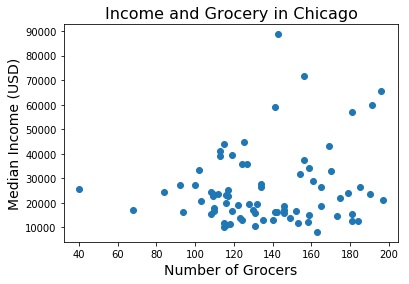

In [124]:
y = df_result['PCI']
x = df_result['# Grocers']

mpl.pyplot.scatter(x, y)
mpl.pyplot.xlabel('Number of Grocers',size=14)
mpl.pyplot.ylabel('Median Income (USD)',size=14)
mpl.pyplot.title('Income and Grocery in Chicago',size=16)

df_result.corr(method='pearson', min_periods=1)

In [110]:
mlat =np.mean(a['Lat'])
mlong = np.mean(a['Long'])
venues_map = folium.Map(location=[mlat,mlong], zoom_start=9)
for Lat, Long, Neighborhood in zip(a.Lat, a.Long, a.Neighborhood):
    folium.CircleMarker(
        [Lat, Long],
        radius=.5,
        color='blue',
        #popup=Neighborhood,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

In [112]:
venues_map #location of each of the neighborhoods